In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

np.random.seed(1)

In [4]:
def load_signs_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

y = 4


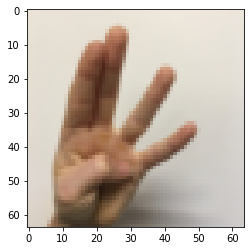

In [3]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [19]:
np.eye(6)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [27]:
print(np.eye(6)[Y_train_orig.reshape(-1)[0]])
print(np.eye(6)[Y_train_orig.reshape(-1)[0]].shape)

[0. 0. 0. 0. 0. 1.]
(6,)


In [28]:
def convert_to_one_hot(Y, C):
    # np.eye(N): Return a 2-D array with ones on the diagonal and zeros elsewhere. N is number of rows
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [29]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [31]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    """

    input_img = tf.keras.Input(shape=input_shape)
    # CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(8, 4, padding = 'same')(input_img)
    # RELU
    A1 = tfl.ReLU()(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=(8,8), strides=8, padding='same')(A1)
    # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(16, 2, padding = 'same')(P1)
    # RELU
    A2 = tfl.ReLU()(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size=(4,4), strides=4, padding='same')(A2)
    # FLATTEN
    F = tfl.Flatten()(P2)
    # Dense layer
    # 6 neurons in output layer.
    outputs = tfl.Dense(6, activation='softmax')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [32]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         392       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 16)          0         
                               

2022-08-15 18:39:47.714307: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-15 18:39:47.716283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100


2022-08-15 18:39:54.050729: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-15 18:39:54.054791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 47ms/step - loss: 1.8066 - accuracy: 0.1713 - val_loss: 1.7896 - val_accuracy: 0.2083
Epoch 2/100
 3/17 [====>.........................] - ETA: 0s - loss: 1.7914 - accuracy: 0.1771

2022-08-15 18:39:54.951754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 38ms/step - loss: 1.7883 - accuracy: 0.2102 - val_loss: 1.7850 - val_accuracy: 0.2750
Epoch 3/100
17/17 [==============================] - 1s 43ms/step - loss: 1.7832 - accuracy: 0.2843 - val_loss: 1.7803 - val_accuracy: 0.2667
Epoch 4/100
17/17 [==============================] - 1s 36ms/step - loss: 1.7789 - accuracy: 0.2676 - val_loss: 1.7773 - val_accuracy: 0.2417
Epoch 5/100
17/17 [==============================] - 1s 38ms/step - loss: 1.7744 - accuracy: 0.3000 - val_loss: 1.7729 - val_accuracy: 0.2750
Epoch 6/100
17/17 [==============================] - 1s 40ms/step - loss: 1.7685 - accuracy: 0.3056 - val_loss: 1.7671 - val_accuracy: 0.2917
Epoch 7/100
17/17 [==============================] - 1s 38ms/step - loss: 1.7610 - accuracy: 0.3222 - val_loss: 1.7597 - val_accuracy: 0.2500
Epoch 8/100
17/17 [==============================] - 1s 38ms/step - loss: 1.7500 - accuracy: 0.3759 - val_loss: 1.7479 - val_accuracy: 0.3417
Epoch 9/100
17/17 

17/17 [==============================] - 1s 44ms/step - loss: 0.5671 - accuracy: 0.8139 - val_loss: 0.6964 - val_accuracy: 0.7750
Epoch 60/100
17/17 [==============================] - 1s 41ms/step - loss: 0.5595 - accuracy: 0.8120 - val_loss: 0.6889 - val_accuracy: 0.7750
Epoch 61/100
17/17 [==============================] - 1s 38ms/step - loss: 0.5521 - accuracy: 0.8157 - val_loss: 0.6848 - val_accuracy: 0.7750
Epoch 62/100
17/17 [==============================] - 1s 37ms/step - loss: 0.5445 - accuracy: 0.8176 - val_loss: 0.6774 - val_accuracy: 0.7750
Epoch 63/100
17/17 [==============================] - 1s 39ms/step - loss: 0.5378 - accuracy: 0.8194 - val_loss: 0.6734 - val_accuracy: 0.7833
Epoch 64/100
17/17 [==============================] - 1s 36ms/step - loss: 0.5306 - accuracy: 0.8250 - val_loss: 0.6680 - val_accuracy: 0.7833
Epoch 65/100
17/17 [==============================] - 1s 37ms/step - loss: 0.5244 - accuracy: 0.8231 - val_loss: 0.6614 - val_accuracy: 0.7833
Epoch 66/100

In [34]:
history.history

{'loss': [1.8066388368606567,
  1.7882744073867798,
  1.7831580638885498,
  1.7788827419281006,
  1.7743539810180664,
  1.7684541940689087,
  1.7609814405441284,
  1.7499910593032837,
  1.7351621389389038,
  1.7165616750717163,
  1.6927558183670044,
  1.6639958620071411,
  1.6308274269104004,
  1.590316891670227,
  1.546755313873291,
  1.500910997390747,
  1.452646017074585,
  1.4083504676818848,
  1.3608499765396118,
  1.3162529468536377,
  1.2750804424285889,
  1.2347893714904785,
  1.1977423429489136,
  1.1605310440063477,
  1.129967451095581,
  1.0991902351379395,
  1.0661085844039917,
  1.0399633646011353,
  1.013276219367981,
  0.9889268279075623,
  0.9657014012336731,
  0.9435394406318665,
  0.9227094650268555,
  0.9023622274398804,
  0.8822270035743713,
  0.8620337843894958,
  0.8427543044090271,
  0.8254033923149109,
  0.8065516948699951,
  0.7881810069084167,
  0.7732909321784973,
  0.7550822496414185,
  0.7425410151481628,
  0.7281060814857483,
  0.7125417590141296,
  0.7002

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

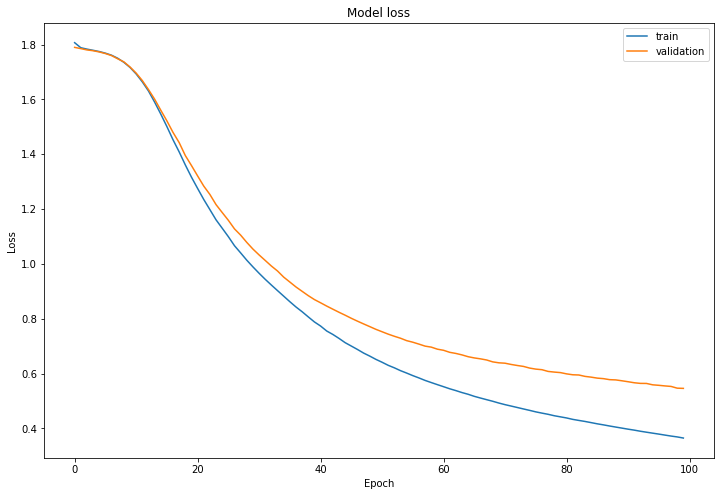

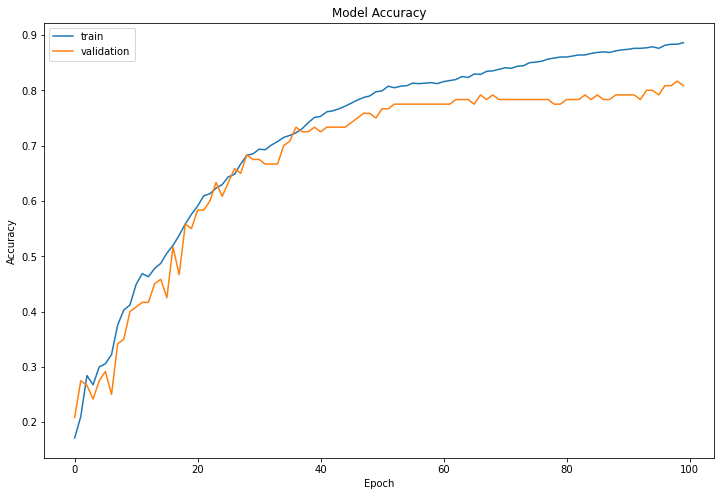

In [36]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the model was trained on. 
pd.options.mode.chained_assignment = None  # default='warn'
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')